In [1]:
# Import required modules
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import requests
from LeXmo import LeXmo
import pickle
import os
from tqdm.notebook import tqdm
import statsmodels.formula.api as sm
from scipy.stats import t 
import matplotlib.pyplot as plt
import sys

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Parameters

In [2]:
sp = "sp500" # sp500 or sp600

In [3]:
# Load earning calls to be analysed
df_path = "data/earning_call_dataframe/df_final_"+sp  
with open(df_path,"rb") as file :
    df_final = pickle.load(file)

In [4]:
display(df_final)

,id,date,ticker,text,earning_call_quarter
0,4264085,2019-05-14,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q1
1,4285738,2019-08-14,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q2
2,4309111,2019-11-26,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q3
3,4325101,2020-02-18,A,Question-and-Answer Session\n \nOperator\n \n[...,2019Q4
4,4349475,2020-05-21,A,Question-and-Answer Session\n \nOperator\n \n[...,2020Q1
...,...,...,...,...,...
1855,4422752,2021-04-30,DRE,Question-and-Answer Session\n \nOperator\n \n[...,2021Q1
1856,4442846,2021-07-29,DRE,Question-and-Answer Session\n \nOperator\n \nT...,2021Q2
1857,4463265,2021-10-28,DRE,Question-and-Answer Session\n \nOperator\n \nT...,2021Q3
1858,4482287,2022-01-27,DRE,Question-and-Answer Session \n \nOperator\n \n...,2021Q4


# Import datas from yahoo finance

In [5]:
# Get the month from which we import stock returns :
    # Q1 : from january (1) to march (3)
    # Q2 : from april (4) to june (6)
    # Q3 : from july (7) to septmber (9)
    # Q4 : from october (10) to december (12)

#df_final['earning_call_quarter'] = pd.to_datetime(df_final['earning_call_quarter'])
df_final['date'] = pd.to_datetime(df_final['date'])

# Quarters start and end
quarter_start = df_final['earning_call_quarter'].iloc[0].quarter
quarter_end = df_final['earning_call_quarter'].iloc[-1].quarter 

# Months start and end
month_start = quarter_start*2-1
month_end = quarter_end*3

# Day end : 30 or 31 ?
if month_end in [3,12]:
    day_end = 31
else:
    day_end = 30

In [6]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

# Take a margin of 1 year to calculate abnormal returns
start = datetime.datetime(df_final['earning_call_quarter'].iloc[0].year-1,month_start,2)
end   = datetime.datetime(df_final['earning_call_quarter'].iloc[-1].year+1,month_end,day_end)

# Create empty dataframe
stock_final = pd.DataFrame()

# Iterate over each symbol
list_tickers = list(set(list(df_final['ticker'])))
for i in list_tickers:  
    
    # Print the symbol which is being downloaded
    print( str(list_tickers.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # Download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # Append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['ticker']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
        
display(stock_final)

0 : ADP,1 : BKR,2 : CDAY,3 : A,4 : CI,5 : CPT,6 : ABMD,7 : ABBV,8 : APH,9 : DFS,10 : AEE,11 : DAL,12 : BAC,13 : ADSK,14 : CVS,15 : APD,16 : CDNS,17 : CSX,18 : ALL,19 : ALK,20 : AOS,21 : CHD,22 : BRO,23 : BMY,24 : AEP,25 : APA,26 : DD,27 : AXP,28 : AVY,29 : BDX,30 : AME,31 : CMG,32 : BLK,33 : BK,34 : CB,35 : CHTR,36 : BR,37 : DHR,38 : ADM,39 : AZO,40 : ALGN,41 : DHI,42 : DOV,43 : ALB,44 : BA,45 : DLTR,46 : ANET,47 : DGX,48 : BALL,49 : BIIB,50 : CCI,51 : C,52 : AMZN,53 : ABT,54 : ATO,55 : DE,56 : ANTM,57 : AON,58 : DRE,59 : AES,60 : CAT,61 : BBY,62 : BBWI,63 : CTSH,64 : D,65 : CME,66 : AAL,67 : BXP,68 : DLR,69 : CZR,70 : AIG,71 : CMA,72 : AAPL,73 : APTV,74 : CMI,75 : AMP,76 : AIZ,77 : ARE,78 : AVB,79 : CINF,80 : ANSS,81 : CF,82 : COF,83 : BEN,84 : BKNG,85 : AMAT,86 : CL,87 : AKAM,88 : CAH,89 : CE,90 : BSX,91 : CMS,92 : CBOE,93 : CLX,94 : CBRE,95 : DIS,96 : CHRW,97 : CDW,98 : DG,99 : AFL,

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2018-01-02,116.029999,116.449997,115.250000,115.989998,105.598389,2453000,ADP
2018-01-03,116.180000,117.699997,115.599998,117.250000,106.745522,1521500,ADP
2018-01-04,117.629997,118.900002,117.470001,118.370003,107.765167,1236900,ADP
2018-01-05,118.550003,118.769997,117.260002,118.300003,107.701454,1451100,ADP
2018-01-08,118.370003,118.580002,117.389999,117.940002,107.373703,2683000,ADP
...,...,...,...,...,...,...,...
2022-06-13,54.700001,54.849998,53.490002,53.740002,53.740002,3068300,AFL
2022-06-14,54.060001,54.570000,53.279999,53.709999,53.709999,2138700,AFL
2022-06-15,54.220001,54.869999,53.430000,54.230000,54.230000,2650800,AFL


In [7]:
# Saves datas
df_path = "data/"+sp+"/stock_final_"+sp
with open(df_path,"wb") as file : 
    pickle.dump(stock_final, file, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open(df_path,"rb") as file :
    stock_final = pickle.load(file)

# Drop useless columns
stock_final = stock_final.drop(columns = ['Open','High','Low','Close','Volume'])
stock_final = stock_final.reset_index()
stock_final = stock_final.groupby(['ticker','Date']).last()

# Calculate stock returns
stock_final['stock_return'] = stock_final['Adj Close'].pct_change()

# Remove first date of each stock
stock_final = stock_final.drop(stock_final.groupby('ticker',as_index=False).nth(0).index)
stock_final = stock_final.reset_index()
stock_final = stock_final.drop(columns = ['Adj Close'])
display(stock_final)

,ticker,Date,stock_return
0,A,2018-01-03,0.025444
1,A,2018-01-04,-0.007502
2,A,2018-01-05,0.015988
3,A,2018-01-08,0.002146
4,A,2018-01-09,0.024554
...,...,...,...
112216,DRE,2022-06-13,0.009843
112217,DRE,2022-06-14,0.018500
112218,DRE,2022-06-15,0.048437
112219,DRE,2022-06-16,-0.028502


In [9]:
# Market datas

# Market ticker
if sp == "sp500":
    sp_ticker = 'SPY' 
elif sp == "sp600":
    sp_ticker = '^SP600' 

# Import market datas
mkt =  yf.download(sp_ticker, start=start, end=end, progress=False)
# Compute market return
mkt['market_return'] = mkt['Adj Close'].pct_change()
mkt = mkt.drop(columns = ['Adj Close','Open','High','Low','Close','Volume'])
# Drop first row
mkt = mkt[1:]

# Abnormal returns

In [10]:
# Parameter
number_days_end = 30
number_days_start = 30

# Initialisation of final dataframe
df_plot = pd.DataFrame(data={'normalized_date': np.arange(-number_days_start , number_days_end+1, 1, dtype=int)})

# Vector of normalized_date
normalized_date = np.concatenate((np.arange(-number_days_start , 0, 1, dtype=int),[0], np.arange(0, number_days_end +1, 1, dtype=int)))

# Get list of different tickers of the dataframe
list_tickers = list(set(list(df_final['ticker'])))

In [11]:
for symbol in tqdm(list_tickers):

    # Calculate abnormal returns of each stock
    df_stock = stock_final[stock_final['ticker'] == symbol]
    df_stock = df_stock.set_index('Date')
    df_stock = pd.merge(df_stock, mkt, left_index=True, right_index=True)
    df_stock['abnormal_return'] = df_stock['stock_return']-df_stock['market_return']
    df_stock = df_stock.drop(columns = ['stock_return', 'market_return'])
    # Id value for row of return are max int
    df_stock['id'] = sys.maxsize*len(df_stock)
    first_column = df_stock.pop('id')
    df_stock.insert(0, 'id', first_column)

    # Dataframe with publication date of earning transcript
    df_final_stock = df_final[df_final['ticker'] == symbol]
    df_final_stock= df_final_stock.set_index('date')
    df_final_stock = df_final_stock.drop(columns = ['earning_call_quarter','text'])
    df_final_stock['abnormal_return']=0*len(df_final_stock)

    # Concatenate 2 previous dataframe and sort by date
    result = pd.concat([df_stock,df_final_stock])
    result = result.reset_index()
    result = result.rename(columns={'index': 'date'})
    result = result.sort_values(by=['date', 'id'])
    # if trading day : 
    ###### [return i-1, publication row date i , return i , return i+1]
    # for non trading day publication
    ###### [return i-1, return i, publication row date (i+1-i)/2, return i+1 , return i+2 ]
    # where return i = (Price i - Price i-1)/Price i-1
    # so for both case the first return of the position that we take from the strategy is 2 element to the
    # right from the publication row. For publication in trading day date i it is return i+1 as position is taken at Price i 
    # so return is return i+1 = (Price i+1 -Price i )/Price i
    # for publication in non trading day date (i+1-i)/2 it is return i+1 as position is take at Price i+1 
    # so return is return i+1 = (Price i+2- Price i+1)/Price i+1
    result = result.reset_index()

    # Get the indices of parution dates
    indices = result.loc[result['abnormal_return'] == 0].index.values
    indices = indices[:-1] # remove most recent earning call

    for i in indices: # Loop for each earning call 
        first_df=[]
        # Keep only the abnormal returns in the time window around publication date
        # The first left element in respect to publication row date is the relative abnormal return -1
        first_df = result[i-(number_days_start) :i+(number_days_end+2)]
        # Add normalized date
        first_df['normalized_date']=normalized_date
        # Delete other ootential earning calls
        first_df=first_df[first_df.index != i]
        # Compute cumulative abnormal returns
        first_df['cum_ab_return']=first_df['abnormal_return'].cumsum(axis = 0)
        # Keep enring call id for column name
        column_title= result['id'].loc[i]
        # Add erning call abnormal returns if df_plot
        df_plot[column_title]=first_df['cum_ab_return'].values

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/m3/zvz37scs6vj6_wyjn348qj800000gn/T/ipykernel_14118/2931937211.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_df['normalized_date']=normalized_date
/var/folders/m3/zvz37scs6vj6_wyjn348qj800000gn/T/ipykernel_14118/2931937211.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plot[column_title]=first_df['cum_ab_return'].values


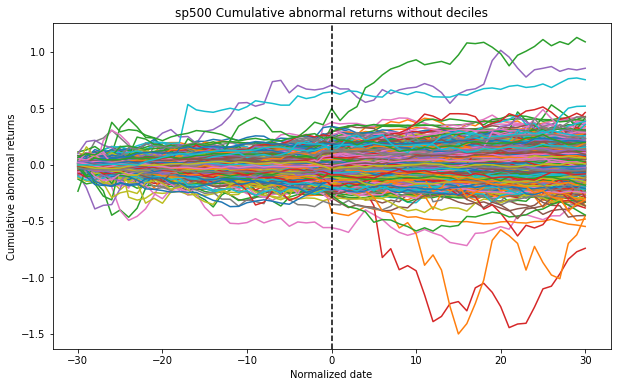

In [12]:
# Stock all earning call ids in a list
col = list(df_plot)
col.remove('normalized_date')
# Plot cumulative abnormal returns without deciles
title = sp+" Cumulative abnormal returns without deciles"
plot = df_plot.plot(x='normalized_date',y=col,figsize=(10,6))
plot.get_legend().remove()
plt.axvline(x=0,color="black",linestyle="--")
plt.xlabel("Normalized date")
plt.ylabel("Cumulative abnormal returns")
plt.title(title)
plt.savefig('./data/abnormal_graphs/'+title, bbox_inches='tight')

In [13]:
def plot_with_deciles(col,score_method,content,score):
    # plot abnormal returns 
    # inputs : col             : list of all earning calls id
    #          score_method    : 'FiGAS' or 'FinBert'
    #          content         : 'text' or 'corpus'
    #          score           : name of the score on which we created our deciles : 
    #                            'sent_score' or 'sent_score_rough' for FiGAS ;  "Difference ratio" for FinBert            
    
    # Get csv score file
    file = "data/sentiment_score/"+score_method+"/"+score_method+ "_" + sp +"_by_"+content +"_final.csv"
    merged = []
    # Create score dataframe
    sentiment_text = pd.read_csv(file)  
    if score_method =='FiGAS':
        sentiment_text = sentiment_text.drop(columns = ['Unnamed: 0'])
    if score_method =='FinBert':
        sentiment_text = sentiment_text.rename(columns={"ID": "id"})
    sentiment_text['id'] = sentiment_text['id'].map(str)

    # Get the earning call ids in a dataframe
    col_id = pd.DataFrame(col, columns =['id'])

    # Merge call ids with score csv (to be sure that we have the same ids)
    merged = pd.merge(col_id, sentiment_text, on='id')
    merged = merged.sort_values(by=[score])

    # Create deciles
    merged['decile'] = 1+ pd.qcut(merged[score], 10, labels=False,duplicates='drop')

    # Compute mean abnormal returns for each decile
    df_decile_plot = []
    df_decile_plot = pd.DataFrame(data={'normalized_date': np.arange(-number_days_start , number_days_end+1, 1, dtype=int)})

    for i in range(1,11):
        dec1 = merged.loc[merged['decile'].isin([i])]
        long1 = dec1.id
        long1 = long1.to_list()

        df_mean = df_plot[long1].mean(axis=1)
        df_decile_plot['decile'+str(i)]=df_mean

    # Plot
    col = list(df_decile_plot)
    col.remove('normalized_date')
    title = sp+" Cumulative abnormal returns based on " +score_method+ " score (using "+ content + " and "+ score+")"
    plot = df_decile_plot.plot(x='normalized_date',y=col,figsize=(10,6))
    plt.axvline(x=0,color="black",linestyle="--")
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.xlabel("Normalized date")
    plt.ylabel("Cumulative abnormal returns")
    if sp == "sp600" : 
        y_limit = [-0.04, 0.065];
    elif sp == "sp500" :
        y_limit = [-0.04, 0.04];
    plt.ylim(y_limit)
    plt.title(title)
    plt.savefig('./data/abnormal_graphs/'+title, bbox_inches='tight')

# Figas

## sent_score

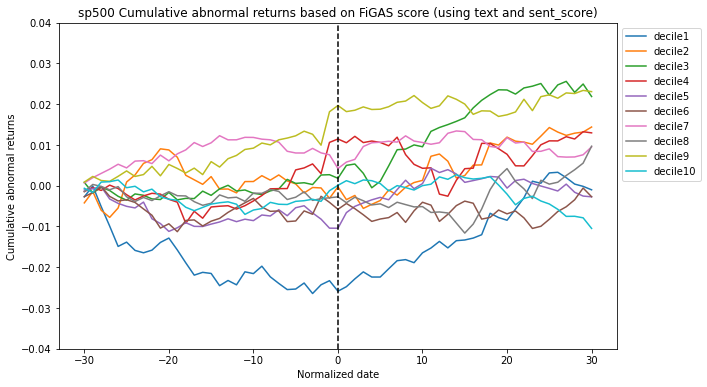

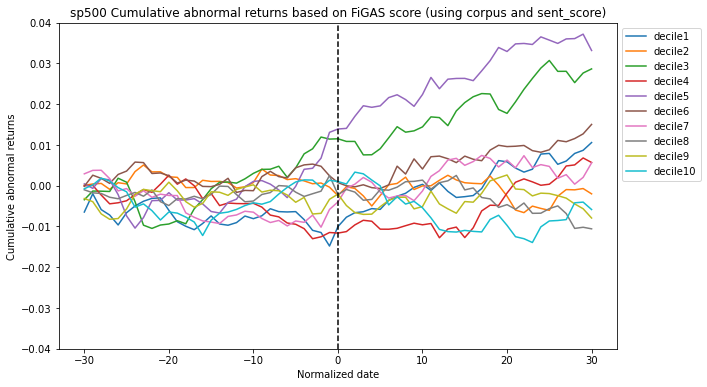

In [14]:
plot_with_deciles(col,'FiGAS','text','sent_score')
plot_with_deciles(col,'FiGAS','corpus','sent_score')

## sent_score_rough

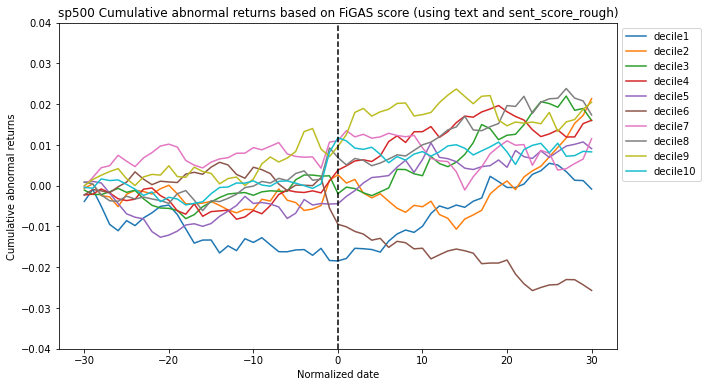

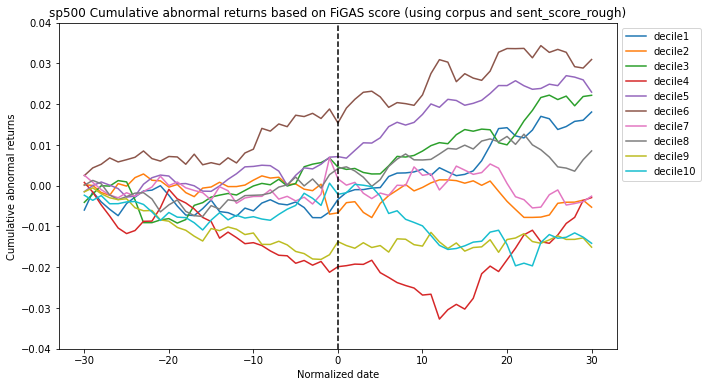

In [15]:
plot_with_deciles(col,'FiGAS','text','sent_score_rough')
plot_with_deciles(col,'FiGAS','corpus','sent_score_rough')

# FinBert

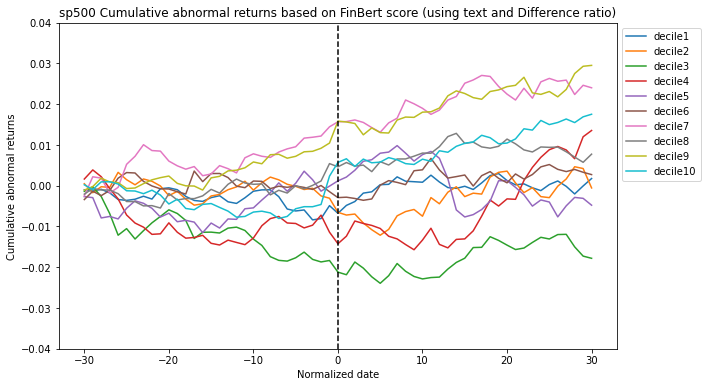

In [16]:
plot_with_deciles(col,'FinBert','text','Difference ratio')